In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import CSV File

volatility_df = pd.read_csv("UpdatedGammaVix.csv")

In [3]:
volatility_df

,date,price,Vix Previous Close,Vix 21 Moving Average,SPX Change,DIX Previous Close,GEX Previous Close,MOVE
0,5/31/11,1345.199951,15.980000,16.911429,0.010593,0.400935,9.186650e+08,71.50
1,6/1/11,1314.550049,15.450000,17.021429,-0.022785,0.402477,1.501019e+09,72.90
2,6/2/11,1312.939941,18.299999,17.087619,-0.001225,0.441582,7.654729e+08,76.60
3,6/3/11,1300.160034,18.090000,17.129048,-0.009734,0.413070,7.370545e+08,75.90
4,6/6/11,1286.170044,17.950001,17.142857,-0.010760,0.436110,4.059565e+08,75.80
...,...,...,...,...,...,...,...,...
2879,11/4/22,3770.550049,25.299999,29.209524,0.013619,0.442476,-6.368992e+08,128.44
2880,11/7/22,3806.800049,24.549999,28.875714,0.009614,0.425303,5.863258e+08,128.33
2881,11/8/22,3828.110107,24.350000,28.546667,0.005598,0.449861,1.164755e+09,126.33
2882,11/9/22,3748.570068,25.540001,28.187619,-0.020778,0.438960,1.395167e+09,124.40


In [4]:
# Create data frame with SPX and Gamma levels

spx_gamma_df = volatility_df[["SPX Change", "GEX Previous Close"]]

Text(0.5, 1.0, 'SPX Change by GEX level')

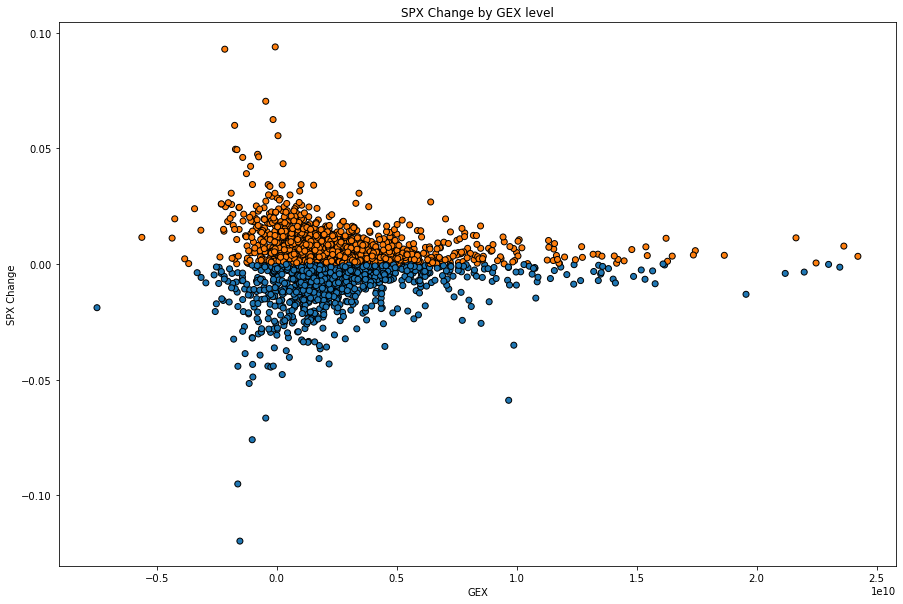

In [5]:
# Graph Relationship between Gamma and SPX Movement

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,10
colors = np.where(spx_gamma_df["SPX Change"] <0, 'C0', 'C1')
plt.scatter(x = spx_gamma_df["GEX Previous Close"], y = spx_gamma_df["SPX Change"],cmap = 'Spectral', edgecolor = 'k', c= colors)
plt.xlabel("GEX")
plt.ylabel("SPX Change")
plt.title("SPX Change by GEX level")

In [6]:
# Calculate Absolute Moves in SPX

volatility_df["Absolute SPX Change"] = volatility_df["SPX Change"].abs()

Text(0.5, 1.0, 'Absolute SPX Change by GEX level')

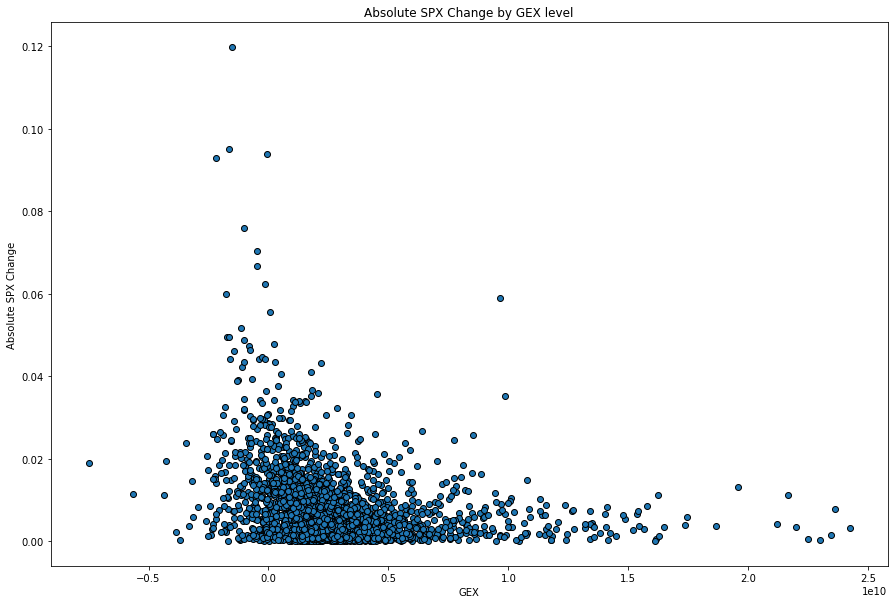

In [7]:
# Graph SPX Change in Absolute move

plt.scatter(x = volatility_df["GEX Previous Close"], y = volatility_df["Absolute SPX Change"],cmap = 'Spectral', edgecolor = 'k')
plt.xlabel("GEX")
plt.ylabel("Absolute SPX Change")
plt.title("Absolute SPX Change by GEX level")

In [8]:
### Observation: In the above graph we see that Gamma Exposure (GEX) plays a big role in determining the 
### day-to-day volatility of the S&P 500 (SPX). As Gamma Exposure increases, the S&P contracts in volatility. 
### As Gamma decreases, S&P volatility increases and we experience wider trading ranges. Due to what this graph shows,
### we believe that we can find a relationship between Actual Realized volatility and Gamma Exposure. Our goal is to 
### find the relationship, and then see if we can compare that to the Implied Volatility to gain a trading edge. 

In [9]:
# Download S&P 500 ETF (SPY) data and create DataFrame

spy_df = yf.download("SPY")

[*********************100%***********************]  1 of 1 completed


In [10]:
# Calculate the Daily Change in S&P 500 ETF

spy_df["Daily Return"] = spy_df["Adj Close"].pct_change()

In [11]:
# Drop Columns

spy_df.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)

In [12]:
# Download CBOE Volatility Index (VIX) data and create DataFrame

vix_df = yf.download("^VIX", start="1993-01-29")

[*********************100%***********************]  1 of 1 completed


In [13]:
# Use "Rule of 16" to determine the One-Day Implied Move in Market

vix_df["Implied One-Day Move"] = (vix_df["Close"] / np.sqrt(252))/100

In [14]:
# Drop Columns

vix_df.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)

In [15]:
# Concatenate VIX and SPY DataFrames

spy_vix_df = pd.concat([spy_df, vix_df], axis=1)

In [16]:
# Drop Columns

spy_vix_df.drop(columns=["Adj Close"], inplace=True)

In [17]:
# Display the Absolute Daily Move in S&P 500 ETF

spy_vix_df["Absolute Daily Return"] = spy_vix_df["Daily Return"].abs()

In [18]:
# Calculate Spread between Implied and Realized Volatility

spy_vix_df["Implied vs. Realized Spread"] =spy_vix_df["Implied One-Day Move"] - spy_vix_df["Absolute Daily Return"]

In [19]:
# Show Stats for Implied vs Realized Spread

spy_vix_df["Implied vs. Realized Spread"].describe()

count    7505.000000
mean        0.004509
std         0.007341
min        -0.110557
25%         0.001440
50%         0.005482
75%         0.008446
max         0.043231
Name: Implied vs. Realized Spread, dtype: float64

Text(0.5, 1.0, 'History of Implied vs Realized Volatility')

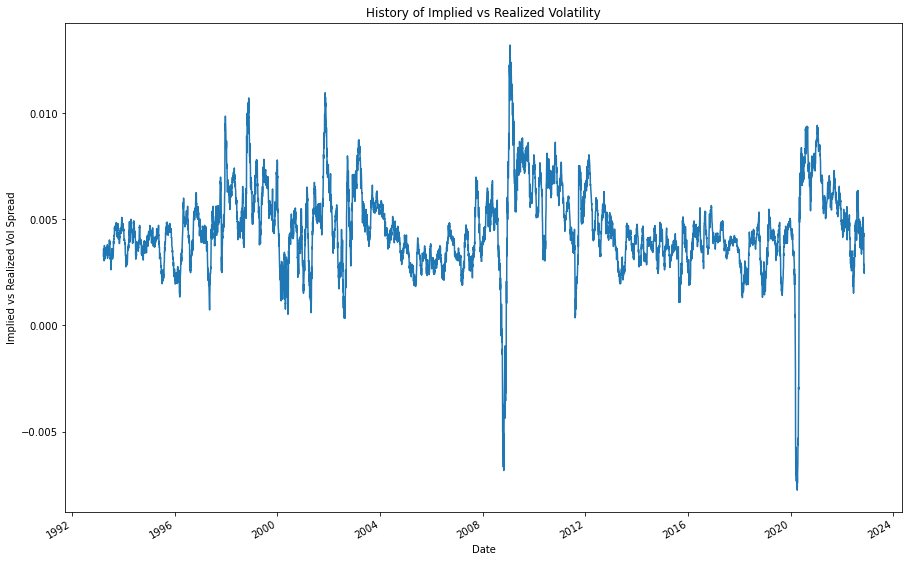

In [20]:
# Plot the 35 day rolling average in Implied vs. Realized Volatility

spy_vix_df["Implied vs. Realized Spread"].rolling(35).mean().plot()
plt.xlabel("Date")
plt.ylabel("Implied vs Realized Vol Spread")
plt.title("History of Implied vs Realized Volatility")

In [21]:
###  Observation: The chart above shows that there is, generally, a premium that is paid by those who buy puts. This
### premium is shown from the spread between Implied vs Realized (Actual) volatility. The chart shows that on average, there is 
### a premium of about 45 basis points over the time span. This means that for a majority of the time, shorting 
### volatility is a profitable strategy. However, As one can see in 2008 and 2020, shorting volatility can be very
### dangerous. This is why it is important to not just short volatility blindly as many funds do. This graph also 
### shows us that some of the best times to short volatility, is right after the worst times. 

In [22]:
### This chart above shows the basis for our project. As the chart shows there is a correct time to short volatility
### and there is an incorrect time to short volatility, and instead buy it. For our project, we aim to better predict
### when to do which. 

In [23]:
volatility_df.head()

,date,price,Vix Previous Close,Vix 21 Moving Average,SPX Change,DIX Previous Close,GEX Previous Close,MOVE,Absolute SPX Change
0,5/31/11,1345.199951,15.980000,16.911429,0.010593,0.400935,9.186650e+08,71.5,0.010593
1,6/1/11,1314.550049,15.450000,17.021429,-0.022785,0.402477,1.501019e+09,72.9,0.022785
2,6/2/11,1312.939941,18.299999,17.087619,-0.001225,0.441582,7.654729e+08,76.6,0.001225
3,6/3/11,1300.160034,18.090000,17.129048,-0.009734,0.413070,7.370545e+08,75.9,0.009734
4,6/6/11,1286.170044,17.950001,17.142857,-0.010760,0.436110,4.059565e+08,75.8,0.010760


In [85]:
# Import Libraries for Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [283]:
# Set X and Y Variables

y = volatility_df["Absolute SPX Change"]
X = volatility_df.drop(columns=["Absolute SPX Change", "date", "SPX Change", "price"])

In [284]:
# Split train and Test Data

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [285]:
# Set Scaler

scaler = StandardScaler()

In [286]:
# Scale Data

X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [287]:
# Import ML Regressor

from sklearn.ensemble import RandomForestRegressor

In [288]:
# Set Model

model = RandomForestRegressor()

In [289]:
# Fit Model

model.fit(X_train,y_train)

RandomForestRegressor()

In [290]:
# Make Predictions

y_pred = model.predict(X_test)

In [291]:
# View Model Score

model.score(X,y)

0.7554330965340342

In [292]:
r2_score(y_pred, y_test)

-0.7013846258790177

In [294]:
np.sqrt(mean_squared_error(y_pred, y_test))

0.007080254309130224

In [99]:
results_df = pd.DataFrame(y_pred, y_test)

In [103]:
vix_absolute_df = volatility_df[["Vix Previous Close", "Absolute SPX Change"]]

In [106]:
vix_absolute_df.set_index("Absolute SPX Change", inplace=True)

In [108]:
vix_predict_abs = vix_absolute_df.join(results_df)

In [111]:
vix_predict_abs.reset_index(inplace=True)

In [115]:
vix_predict_abs.dropna(inplace=True)

In [136]:
vix_predict_abs["Implied SPX Move"] = (vix_predict_abs["Vix Previous Close"]/np.sqrt(252))/100

KeyError: 'Vix Previous Close'

In [137]:
vix_predict_abs.drop(columns=["Vix Previous Close"], inplace=True)

KeyError: "['Vix Previous Close'] not found in axis"

In [139]:
vix_predict_abs

,Absolute SPX Change,0,Impled SPX Move
3,0.009734,0.010082,0.011396
4,0.010760,0.010898,0.011307
6,0.004187,0.008245,0.011383
10,0.012612,0.007551,0.012353
13,0.003045,0.011719,0.014319
...,...,...,...
2853,0.021126,0.023452,0.019012
2854,0.015067,0.025949,0.020057
2860,0.007492,0.022634,0.019755
2881,0.005598,0.012846,0.015339


In [146]:
vix_predict_abs["Model Delta"] = (vix_predict_abs[0] - vix_predict_abs["Absolute SPX Change"]).abs()

In [147]:
vix_predict_abs["VIX Delta"] = (vix_predict_abs["Impled SPX Move"] - vix_predict_abs["Absolute SPX Change"]).abs()

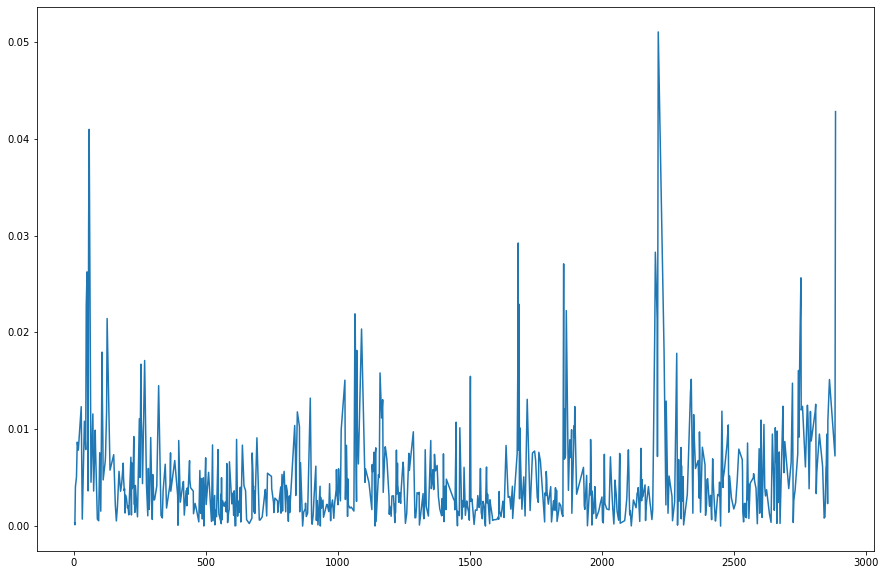

In [150]:
model_delta_plot = vix_predict_abs["Model Delta"].plot()

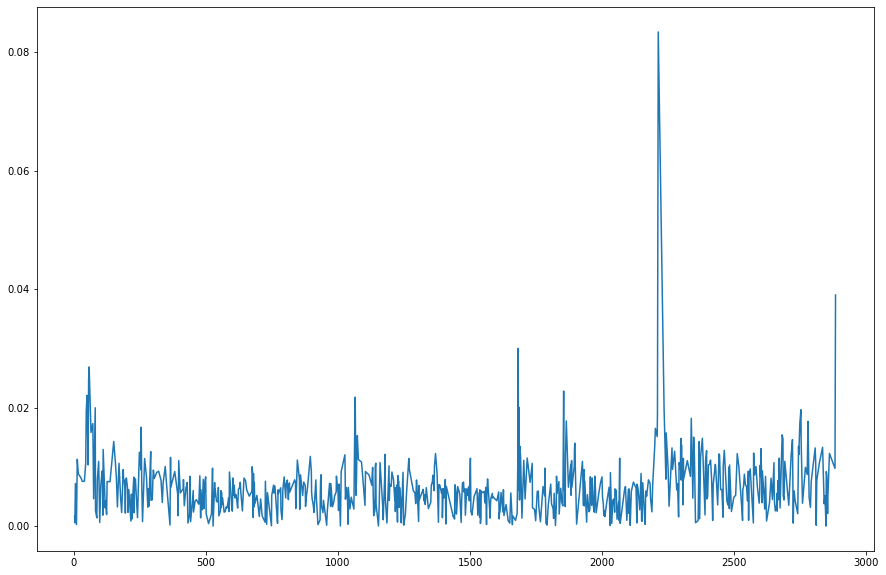

In [151]:
vix_delta_plot = vix_predict_abs["VIX Delta"].plot()

In [153]:
vix_predict_abs["Model Delta"].describe()

count    721.000000
mean       0.004832
std        0.005261
min        0.000006
25%        0.001669
50%        0.003279
75%        0.006422
max        0.051038
Name: Model Delta, dtype: float64

In [154]:
vix_predict_abs["VIX Delta"].describe()

count    721.000000
mean       0.006432
std        0.005270
min        0.000003
25%        0.003227
50%        0.005865
75%        0.008312
max        0.083385
Name: VIX Delta, dtype: float64

<AxesSubplot:>

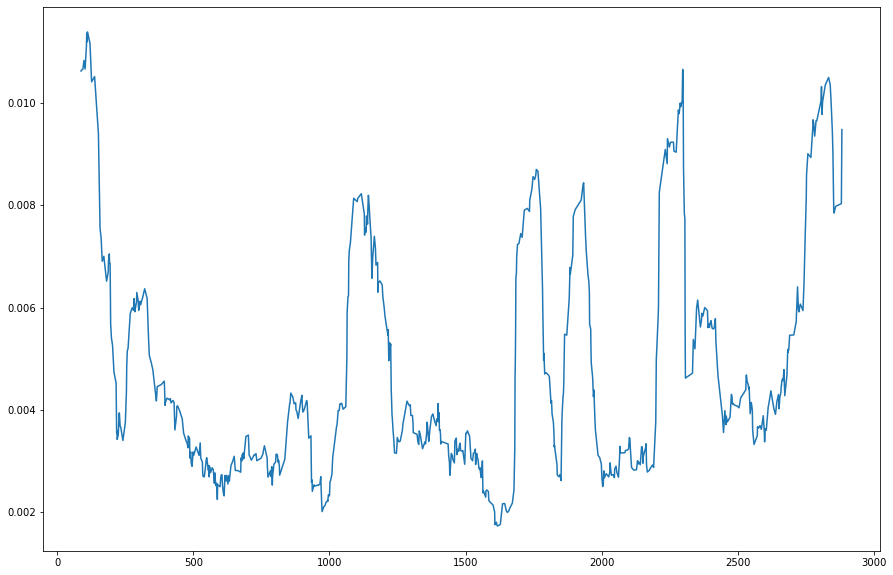

In [155]:
vix_predict_abs["Model Delta"].rolling(21).mean().plot()

<AxesSubplot:>

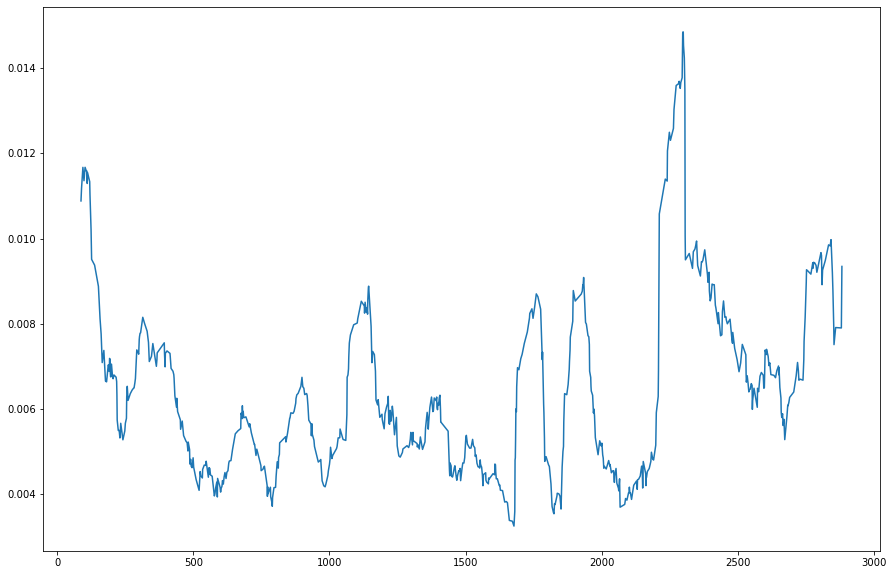

In [158]:
vix_predict_abs["VIX Delta"].rolling(21).mean().plot()

<AxesSubplot:>

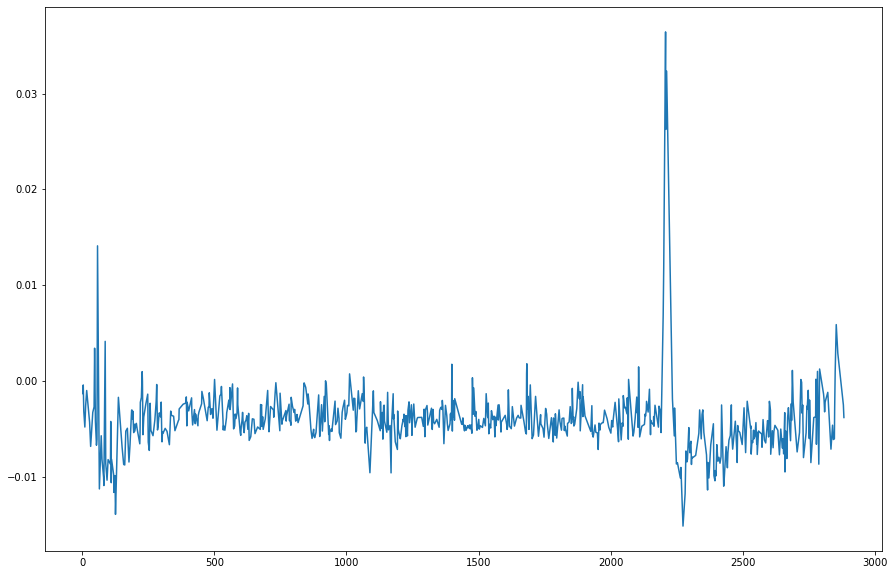

In [164]:
(vix_predict_abs[0] - vix_predict_abs["Impled SPX Move"]).plot()

<AxesSubplot:>

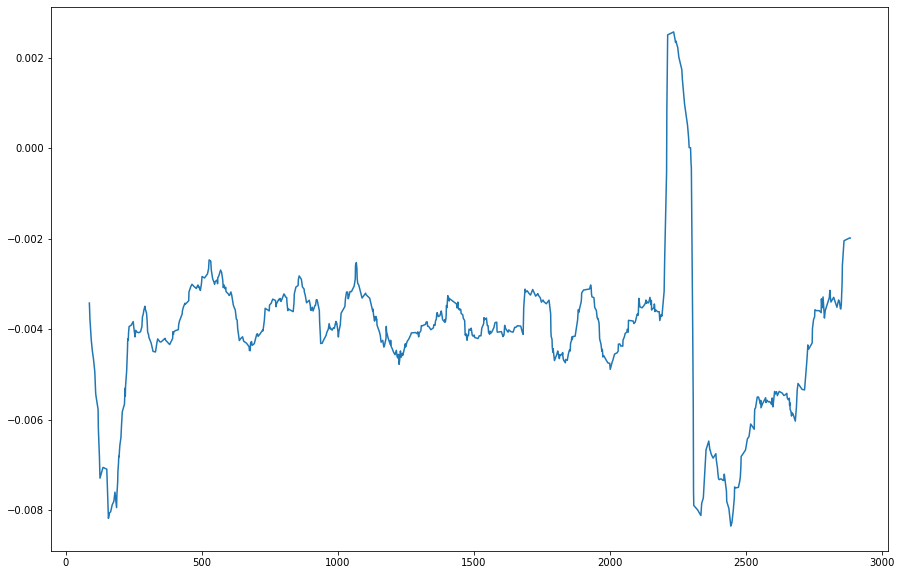

In [165]:
(vix_predict_abs[0] - vix_predict_abs["Impled SPX Move"]).rolling(21).mean().plot()

In [34]:
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.007129477133786902

In [36]:
r2_score(y_test, y_pred)

0.3369986119011853

In [37]:
# Label Features

importances_names = model.feature_names_in_

In [38]:
# Set Importances

importances=model.feature_importances_

In [39]:
# Make DataFrame

importances_df = pd.DataFrame(importances,importances_names)

In [40]:
# Sort Values by Importance

importances_df.sort_values(by=0, ascending=False)

,0
Vix Previous Close,0.460683
GEX Previous Close,0.161458
MOVE,0.133937
Vix 21 Moving Average,0.123501
DIX Previous Close,0.120421


Text(0.5, 1.0, 'Feature Importance from Random Forest')

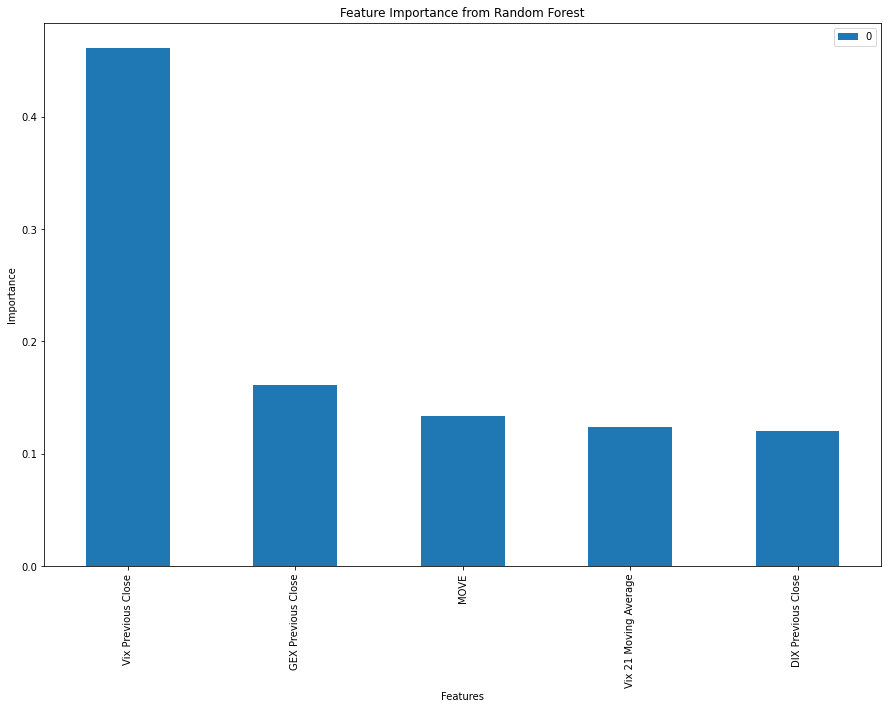

In [41]:
# Graph Importances

importances_df.sort_values(by = 0, ascending=False).plot(kind = "bar")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance from Random Forest")

In [42]:
### Insight: For the model below, we wanted to see what the effect of Top of Book Liquidity would have on volatility. 
### We hypothesize that the less liquidity there is in markets, the more volatile the market is. Unfortunately, data
### for what we are trying to model here is very hard to obtain. Top of Book Liquidity data via the Chicago Mercantile
### Exchange (CME), was going to cost ~$19k if we wanted to capture the data that goes back to the May 31, 2011 start
### date in our other data collected above. Fortunately, the CME provides 2-year sample data we were able to use to at 
### least get a fraction of our time period. The results from that data are below. 


In [43]:
# Import CSV file and create DataFrame

top_of_book_df = pd.read_csv("iiiaaa.csv")

In [44]:
top_of_book_df

,date,price,Vix Previous Close,Vix 21 Moving Average,SPX Change,DIX Previous Close,GEX Previous Close,MOVE,Top of Book
0,11/16/20,3626.910000,23.100000,29.720476,0.011648,0.431061,6.032393e+09,42.490002,51.7
1,11/17/20,3609.530000,22.450001,29.412381,-0.004792,0.414971,5.568672e+09,43.080002,64.2
2,11/18/20,3567.800000,22.709999,29.150000,-0.011561,0.440556,5.804662e+09,43.619999,73.1
3,11/19/20,3581.850000,23.840000,28.886190,0.003938,0.416999,3.498179e+09,43.529999,51.9
4,11/20/20,3557.540000,23.110001,28.676190,-0.006787,0.438597,5.497968e+09,42.310001,54.5
...,...,...,...,...,...,...,...,...,...
496,11/4/22,3770.550049,25.299999,29.209524,0.013619,0.442476,-6.368992e+08,128.440002,22.1
497,11/7/22,3806.800049,24.549999,28.875714,0.009614,0.425303,5.863258e+08,128.330002,32.5
498,11/8/22,3828.110107,24.350000,28.546667,0.005598,0.449861,1.164755e+09,126.330002,39.2
499,11/9/22,3748.570068,25.540001,28.187619,-0.020778,0.438960,1.395167e+09,124.400002,29.2


In [45]:
# Drop Columns

top_of_book_df.drop(columns=["date", "price"], inplace=True)

In [46]:
# Create column with Absolute SPX move

top_of_book_df["SPX Move"] = top_of_book_df["SPX Change"].abs()

In [47]:
# Drop Columns

top_of_book_df.drop(columns=["SPX Change"], inplace=True)

In [48]:
# Create column that tracks the 7-day rolling average of Top of Book Depth

top_of_book_df["TOB Rolling"] = (top_of_book_df["Top of Book"].rolling(7).mean())

In [49]:
# Drop Columns

top_of_book_df.drop(columns=["Top of Book"], inplace=True)

In [50]:
# Drop Null Values

top_of_book_df.dropna(inplace=True)

In [51]:
# Set Y Variable

y = top_of_book_df["SPX Move"]

In [52]:
# Set X Variable

X = top_of_book_df.drop(columns=["SPX Move"])

In [53]:
# Split train and test data

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [54]:
# Scale Data

X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [55]:
# Call Model

model = RandomForestRegressor()

In [56]:
# Fit Model

model.fit(X_train,y_train)

RandomForestRegressor()

In [57]:
# Make Predictions

y_pred = model.predict(X_test)

In [58]:
# View Model Score

model.score(X,y)

0.6956733798286955

In [59]:
y_pred

array([0.01416984, 0.00497055, 0.00550222, 0.00477669, 0.02325339,
       0.00532584, 0.01562306, 0.00482949, 0.00507364, 0.0190163 ,
       0.01452458, 0.00523032, 0.01314916, 0.00311422, 0.0123916 ,
       0.01645171, 0.01069875, 0.01215258, 0.00442555, 0.00783327,
       0.01273608, 0.00583277, 0.01656708, 0.01083   , 0.00309017,
       0.00469584, 0.00771158, 0.01650175, 0.01002417, 0.01249995,
       0.00544424, 0.00262499, 0.00708089, 0.00581843, 0.01272759,
       0.01807561, 0.01757809, 0.00943304, 0.0046075 , 0.00398706,
       0.01660558, 0.01153095, 0.01684831, 0.01162044, 0.00965067,
       0.00502235, 0.00749957, 0.00813888, 0.00571218, 0.01365867,
       0.01037095, 0.01571832, 0.01492282, 0.01009552, 0.00655931,
       0.00495978, 0.00950624, 0.00755891, 0.00654276, 0.01212531,
       0.00914215, 0.01123399, 0.00457192, 0.01156537, 0.01138002,
       0.01421554, 0.00894179, 0.00383221, 0.01315053, 0.00706535,
       0.0044871 , 0.01141796, 0.01948488, 0.00807138, 0.00418

In [60]:
# Create Feature Importances

importances_names = model.feature_names_in_

In [61]:
# Model Importances

importances=model.feature_importances_

In [62]:
# Create DataFrame of Importances

importances_df = pd.DataFrame(importances,importances_names)

In [63]:
# Sort Importances by Value

importances_df.sort_values(by=0, ascending=False)

,0
TOB Rolling,0.214161
Vix Previous Close,0.186580
MOVE,0.185882
GEX Previous Close,0.165758
DIX Previous Close,0.131189
Vix 21 Moving Average,0.116430


Text(0.5, 1.0, 'Feature Importance from Random Forest')

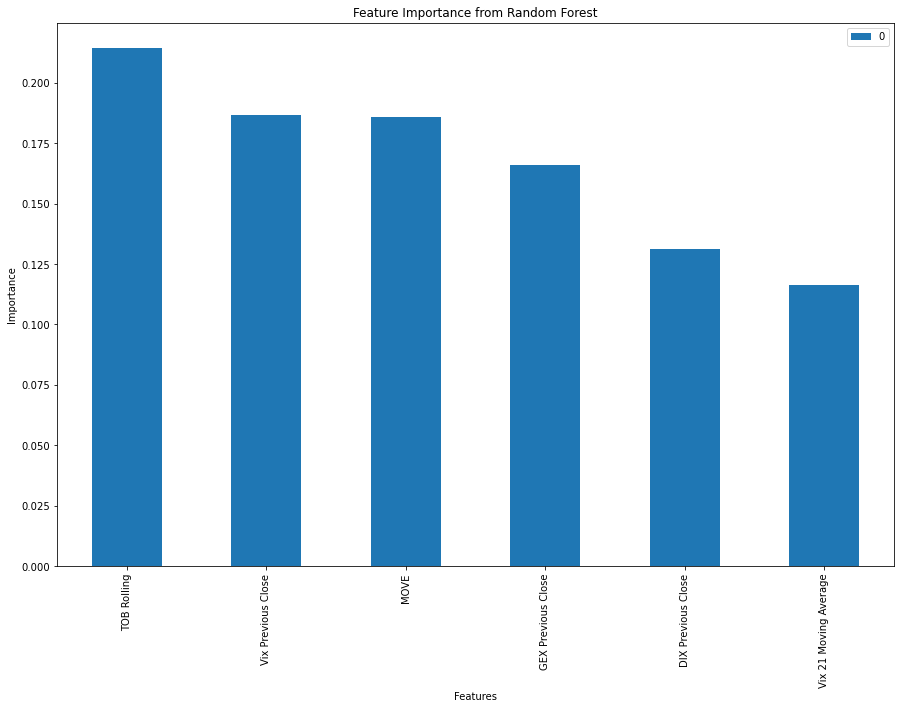

In [64]:
# Graph Importances

importances_df.sort_values(by = 0, ascending=False).plot(kind = "bar")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance from Random Forest")

In [65]:
### There are several interesting ideas to take away from this model. The model had an RMSE score of about 0.7, which
### is slightly less than the previous model's score of about 0.75 . One of the key takeaways, from this model is that
### the time snapshot of the data we were able to obtain, did not feature the major volatility events of 2008, 2018, 
### or 2020. It would have been interesting to see what factor liquidity levels would have had during those highly 
### volatile time periods. Next, we can see that through the feature importance tool that our hypothesis was correct
### in believing that the liquidity, measured by the Top of Book liquidity level, was a major factor in determining
### the levels of realized volatility. As liquidity decreases, the level of volatility increases, and vice-versa. 
### Another key takeaway here, is just the general fluidity and ever-changing mechanics of the stock market. On our
### previous model, factors such as the various VIX measuring instruments played a much more important role in 
### determining volatilty. In this much more narrow model with less data, factors such as treasury market volatility
### (MOVE) were more central to determining market volatility. This coincides with the overall Treasury Market weakness
### we have experienced for a large part of 2022. We believe that had we had data that would have spanned the course
### of the major 2008, 2018, and 2020 volatility events, this feature importance model would have placed more emphasis
### on our various VIX measuring metrics. 


# SVM

In [225]:
# Import Libraries

from sklearn.svm import SVR
from statsmodels.tools.eval_measures import mse

In [226]:
# Set Variables

y = volatility_df["Absolute SPX Change"]
X = volatility_df.drop(columns=["Absolute SPX Change", "date", "SPX Change", "price"])

In [227]:
# Split training and testing data

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [228]:
# Scale Data

X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [229]:
# Set Model

model = SVR(kernel="rbf")

In [230]:
# Fit Model

model.fit(X_train_scaled,y_train)

SVR()

In [231]:
# Make Predictions

y_pred = model.predict(X_test)

/Users/drewhaggerty/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [236]:
model.score(X,y)

/Users/drewhaggerty/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


-21.803965083543897

In [232]:
# Print MSE Score

print(mse(y_pred, y_test))

0.0016920422373464202


In [233]:
y_pred

array([0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755634,
       0.04755634, 0.04755634, 0.04755634, 0.04755634, 0.04755

In [256]:
y = volatility_df["Absolute SPX Change"].values
X = volatility_df["GEX Previous Close"].values.reshape(-1,1)

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [258]:
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [259]:
model = SVR(kernel="rbf", C=1000, epsilon=10)

In [260]:
model.fit(X_train,y_train)

SVR(C=1000, epsilon=10)

In [261]:
y_pred = model.predict(X_test)

In [262]:
print(mse(y_pred, y_test))

0.0016920422373464092


In [263]:
model.score(X,y)

-21.803965083543748

In [266]:
X_train , y_train

(array([[9.27838614e+08],
        [4.14437190e+09],
        [2.53250056e+09],
        ...,
        [1.07486304e+09],
        [1.32658575e+09],
        [2.15234170e+09]]),
 array([0.00991129, 0.00212528, 0.00522187, ..., 0.00803563, 0.01614721,
        0.00262553]))

In [167]:
vix_board_df = pd.read_csv("UpdateGammaVix.csv")

In [170]:
vix_board_df["Vix 3 Spread"] = vix_board_df["Vix 3 Months"] - vix_board_df["VIX Spot"]

In [172]:
vix_board_df["Vix 3-6 Spread"] = vix_board_df["Vix 6 Months"] - vix_board_df["Vix 3 Months"]

In [173]:
vix_board_df

,date,price,VIX Spot,Vix 21 Moving Average,SPX Change,DIX Previous Close,GEX Previous Close,MOVE,Vix 3 Months,Vix 6 Months,Vix 3 Spread,Vix 3-6 Spread
0,5/31/11,1345.199951,15.980000,16.911429,0.010593,0.400935,9.186650e+08,71.50,18.13000,20.01,2.150000,1.88000
1,6/1/11,1314.550049,15.450000,17.021429,-0.022785,0.402477,1.501019e+09,72.90,17.98000,21.41,2.530000,3.43000
2,6/2/11,1312.939941,18.299999,17.087619,-0.001225,0.441582,7.654729e+08,76.60,19.36000,21.29,1.060001,1.93000
3,6/3/11,1300.160034,18.090000,17.129048,-0.009734,0.413070,7.370545e+08,75.90,19.32001,21.59,1.230010,2.26999
4,6/6/11,1286.170044,17.950001,17.142857,-0.010760,0.436110,4.059565e+08,75.80,19.47000,21.81,1.519999,2.34000
...,...,...,...,...,...,...,...,...,...,...,...,...
2879,11/4/22,3770.550049,25.299999,29.209524,0.013619,0.442476,-6.368992e+08,128.44,26.15000,27.78,0.850001,1.63000
2880,11/7/22,3806.800049,24.549999,28.875714,0.009614,0.425303,5.863258e+08,128.33,26.50000,28.00,1.950001,1.50000
2881,11/8/22,3828.110107,24.350000,28.546667,0.005598,0.449861,1.164755e+09,126.33,26.33000,27.94,1.980000,1.61000
2882,11/9/22,3748.570068,25.540001,28.187619,-0.020778,0.438960,1.395167e+09,124.40,27.17000,28.61,1.629999,1.44000


In [198]:
vix_board_df["Backwardation"] = np.where((vix_board_df["Vix 3 Months"] < vix_board_df["VIX Spot"]), 1,0)

In [209]:
vix_board_df

,date,price,VIX Spot,Vix 21 Moving Average,SPX Change,DIX Previous Close,GEX Previous Close,MOVE,Vix 3 Months,Vix 6 Months,Vix 3 Spread,Vix 3-6 Spread,Backwardation
0,5/31/11,1345.199951,15.980000,16.911429,0.010593,0.400935,9.186650e+08,71.50,18.13000,20.01,2.150000,1.88000,0
1,6/1/11,1314.550049,15.450000,17.021429,-0.022785,0.402477,1.501019e+09,72.90,17.98000,21.41,2.530000,3.43000,0
2,6/2/11,1312.939941,18.299999,17.087619,-0.001225,0.441582,7.654729e+08,76.60,19.36000,21.29,1.060001,1.93000,0
3,6/3/11,1300.160034,18.090000,17.129048,-0.009734,0.413070,7.370545e+08,75.90,19.32001,21.59,1.230010,2.26999,0
4,6/6/11,1286.170044,17.950001,17.142857,-0.010760,0.436110,4.059565e+08,75.80,19.47000,21.81,1.519999,2.34000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,11/4/22,3770.550049,25.299999,29.209524,0.013619,0.442476,-6.368992e+08,128.44,26.15000,27.78,0.850001,1.63000,0
2880,11/7/22,3806.800049,24.549999,28.875714,0.009614,0.425303,5.863258e+08,128.33,26.50000,28.00,1.950001,1.50000,0
2881,11/8/22,3828.110107,24.350000,28.546667,0.005598,0.449861,1.164755e+09,126.33,26.33000,27.94,1.980000,1.61000,0
2882,11/9/22,3748.570068,25.540001,28.187619,-0.020778,0.438960,1.395167e+09,124.40,27.17000,28.61,1.629999,1.44000,0


In [269]:
vix_board_df["Absolute SPX Change"] = vix_board_df["SPX Change"].abs()

In [270]:
y = vix_board_df["Absolute SPX Change"]
X = vix_board_df.drop(columns=["Absolute SPX Change", "date", "SPX Change", "price"])

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [272]:
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [273]:
model = RandomForestRegressor()

In [274]:
model.fit(X_train,y_train)

RandomForestRegressor()

In [275]:
y_pred = model.predict(X_test)

In [276]:
model.score(X,y)

0.772594216745768

In [277]:
y_pred

array([0.00452413, 0.00347232, 0.00299567, 0.006616  , 0.005907  ,
       0.00333313, 0.01677037, 0.00438214, 0.0097585 , 0.01149763,
       0.00316927, 0.00511934, 0.01261004, 0.00469148, 0.00291316,
       0.00720671, 0.00244666, 0.00260248, 0.00537523, 0.01170693,
       0.00484903, 0.00595056, 0.00556333, 0.00712133, 0.00943087,
       0.00272907, 0.01347184, 0.00442788, 0.0082833 , 0.00367732,
       0.00574241, 0.00479347, 0.00826392, 0.00647753, 0.00793016,
       0.00310039, 0.0026165 , 0.00906427, 0.00545185, 0.00372362,
       0.01008887, 0.00449379, 0.00528166, 0.02057542, 0.00224937,
       0.00917788, 0.01048712, 0.01157681, 0.00225396, 0.00246855,
       0.00340877, 0.00308821, 0.00233384, 0.0033907 , 0.00481035,
       0.00773748, 0.00455857, 0.01049212, 0.00332357, 0.00287899,
       0.00424787, 0.00937361, 0.00737798, 0.01490092, 0.00469261,
       0.00552063, 0.00391724, 0.01453272, 0.00710808, 0.00590145,
       0.00556707, 0.01009925, 0.00296112, 0.00438372, 0.00233

In [280]:
from sklearn.metrics import r2_score, mean_squared_error

In [279]:
r2_score(y_test, y_pred)

0.36005541209885994

In [282]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.007004411411078864